In this tutorial we embark on the journey of studying FLAML, the auto-ML library developed by Microsoft.

In [1]:
!pip install ray==2.38.0 rgf-python==3.12.0 

In [2]:
!pip install flaml[automl]==2.3.2 flaml[blendsearch]==2.3.2 

In [3]:
# !pip install flaml[ray]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, datetime, loguru
import flaml, sklearn, pickle, rgf

from flaml import AutoML, tune
from flaml.automl.model import SKLearnEstimator # SKLearnEstimator is derived from BaseEstimator
from flaml.automl.data import get_output_from_log
# from ray import tune

from IPython.display import Image
from matplotlib.patches import Patch
from rgf.sklearn import RGFClassifier, RGFRegressor 
from sklearn.datasets import load_iris, fetch_california_housing, fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split

print(flaml.__version__) # 2.3.2
print(sklearn.__version__) # 1.3.0
print(rgf.__version__) # 3.12.0

c:\Users\PGAO\.conda\envs\python310_uat\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-13 19:43:25,767	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-13 19:43:26,307	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
Tried to attach usage logger `pyspark.databricks.pandas.usage_logger`, but an exception was raised: JVM wasn't initialised. Did you call it on executor side?


2.3.2
1.3.0
3.12.0


### COMPUTE REQUIREMENTS

Any UC-enabled cluster from Databricks will work. 

### I. A Warm Start on FLAML

The main class we will be using is `flaml.AutoML`, followed by a standard fit() method and a set of methods of prediction such as predict() and predict_proba() etc..

Let's use the Iris data as an example to allow FLAML to automatically select the best model given a time constraint (denoted by the "time_budget" key-value pair in the `automl_settings` dictionary below):

In [5]:
automl_settings = {
    "time_budget": 30,  # in seconds
    "metric": "accuracy",
    "task": "classification",
    "log_file_name": "iris.log",
    "verbose": True,
}

X, y= load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

automl_model = AutoML()
automl_model.fit(X_train, y_train, **automl_settings)


In [6]:
y_hat = automl_model.predict(X_test)
# print(automl_model.predict_proba(X_test))
accuracy = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Model Accuracy on Test Data: ", accuracy)
print("Model selected by FLAML: ", automl_model.model.estimator)

Model Accuracy on Test Data:  0.9666666666666667
Model selected by FLAML:  SGDClassifier(alpha=0.0004822000992733533, eta0=0.007328089893072002,
              learning_rate='constant', loss='log_loss', n_jobs=-1,
              penalty='l1', tol=0.0001)


### II. Task Oriented AutoML

The class `flaml.AutoML` is a class for task-oriented AutoML. It can be used as a scikit-learn style estimator with the standard fit() and predict() functions. The minimal inputs from users are the training data and the task type.

The training data can either by NumPy arrays or Pandas DataFrame objects (cannot be PySpark at this moment). 

The tasks include the following:

   - 'classification': classification with tabular data;
   - 'regression': regression with tabular data;
   - 'ts_forecast': time series forecasting;
   - 'ts_forecast_classification': time series forecasting for classification;
   - 'ts_forecast_panel': time series forecasting for panel datasets (multiple time series);
   - 'rank': learning to rank;
   - 'seq-classification': sequence classification;
   - 'seq-regression': sequence regression;
   - 'summarization': text summarization;
   - 'token-classification': token classification;
   - 'multichoice-classification': multichoice classification.

Two optional inputs are _time\_budget_ and _max\_iter_ for searching models and hyperparameters. When both are unspecified, only one model per estimator will be trained.

We can pickle the model like below. And then later reload the model:

In [7]:
automl_settings = {
    "time_budget": 30,  # in seconds
    "metric": "mse",
    "task": "regression",
    "log_file_name": "C:\\Users\\PGAO\\GAO\\logs\\california_housing.log",}
artifact_location = "C:\\Users\\PGAO\\GAO\Python_notes"
model_name = "automl.pkl"
model_path = os.path.join(artifact_location, model_name)

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [8]:
automl = AutoML()
automl.fit(X_train, y_train, **automl_settings)
with open(model_path, "wb") as saved_model: # saving the model as a pickle file
    pickle.dump(automl, saved_model, pickle.HIGHEST_PROTOCOL)

[flaml.automl.logger: 11-13 19:45:07] {1728} INFO - task = regression
[flaml.automl.logger: 11-13 19:45:07] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 11-13 19:45:07] {1838} INFO - Minimizing error metric: mse
[flaml.automl.logger: 11-13 19:45:07] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost']
[flaml.automl.logger: 11-13 19:45:07] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 11-13 19:45:07] {2393} INFO - Estimated sufficient time budget=445s. Estimated necessary time budget=4s.
[flaml.automl.logger: 11-13 19:45:07] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.9861,	best estimator lgbm's best error=0.9861
[flaml.automl.logger: 11-13 19:45:07] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-13 19:45:07] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.9861,	best estimator lgbm's best error=0.9861
[flaml.automl.logger: 11-13 19:

In [9]:
with open(model_path, "rb") as f: # loading the model from the pickle file
    automl = pickle.load(f)
y_hat = automl.predict(X_test)

eval_metric = mean_squared_error(y_test, y_hat, squared=False)
print("Evaluation Metric on Test Data: ", eval_metric)
print("Model selected by FLAML: ", automl_model.model.estimator)

Evaluation Metric on Test Data:  0.4510529358672329
Model selected by FLAML:  SGDClassifier(alpha=0.0004822000992733533, eta0=0.007328089893072002,
              learning_rate='constant', loss='log_loss', n_jobs=-1,
              penalty='l1', tol=0.0001)


#### Optimization Metrics

For the fit() method, the optimization metric is specified via the _metric_ argument. It can be either a string which refers to a built-in metric, or a user-defined function. Common metrics include accuracy, log_loss, r2, rmse, mse, mae, mape, roc_auc, f1, micro_f1, macro_f1, ap (average precision) and ndcg score etc.. The ndcg metric stands for normalized discounted cumulative gain which measures the effectiveness of a ranking system by evaluating how well it ranks relevant items. A complete list of the metrics can be found here:

   - https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML

#### Estimators/Models

The estimator list can contain one or more estimator names, each corresponding to a built-in estimator or a custom estimator. Each estimator has a search space for hyperparameter configurations. FLAML supports both classical machine learning models such as logit, various boosting models, tree-based models, arima, sarimax, holt-winters(triple exponential smoothing), prophet, and deep neural networks. Again, the complete list can be found here: 

   - https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML/

If a model is not included in the built-in estimators or models of FLAML, we can build one. For example, we know that the regularized greedy forest (RGF) is an estimator not included in RGF. Think of it like a team of decision trees working together to make better decisions. RGF is suitable for both classification and regression, and we don't need to create dummy variables ourselves. Normalizing data is not necessary but may be helpful for performance. Below in the next paragraph, we give a simple breakdown of how RGF works in layman's term. The original RGF paper can be retrieved here: 

   - https://arxiv.org/abs/1109.0887.

   1. Decision Trees: imagine a decision tree as a flowchart that helps you make decisions by asking a series of questions. Each question splits the data into smaller groups based on the answers.
   2. Ensemble Learning: RGF combines multiple decision trees to improve accuracy. Instead of relying on a single tree, it uses a “forest” of trees, which helps to make more reliable predictions.
   3. Regularization: this is a technique to prevent the model from becoming too complex and overfitting the data (i.e., performing well on training data but poorly on new data). RGF uses regularization to keep the model simple and generalize better to new data.
   4. Greedy Approach: the algorithm builds the forest step-by-step, making the best possible decision at each step to minimize errors. It adjusts the structure of the forest and the weights of the trees to improve performance.


Let's now tune a custom estimator using RGF. Before doing that, let's first look at the original code of RGF:

In [25]:
titanic = fetch_openml('titanic', version=1, as_frame=True)
data = titanic.frame
features = ["pclass", "sex", "sibsp", "parch", "embarked"]
target = "survived"
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = pd.get_dummies(X_train[features])
X_test  = pd.get_dummies(X_test[features])

C:\Users\PGAO\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [10]:
model = RGFClassifier(max_leaf=300, algorithm="RGF_Sib", test_interval=100)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
eval_metric = accuracy_score(y_test , y_hat)
print("The evaluation score is %.5f" % eval_metric)

C:\Users\PGAO\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


The evaluation score is 0.78244


c:\Users\PGAO\.conda\envs\python310_uat\lib\site-packages\rgf\utils.py:224: UserWarning: Cannot find FastRGF executable files. FastRGF estimators will be unavailable for usage.
  warnings.warn("Cannot find FastRGF executable files. "


Let's now use FLAML to do it:

In [11]:
# from flaml.automl.model import SKLearnEstimator # SKLearnEstimator is derived from BaseEstimator
class MyRegularizedGreedyForest(SKLearnEstimator):
    """
    MyRegularizedGreedyForest is a custom estimator that integrates the Regularized Greedy Forest (RGF) algorithm
    with FLAML's AutoML framework. It supports both classification and regression tasks.

    Attributes:
        estimator_class: The class of the estimator (RGFClassifier for classification tasks, RGFRegressor for regression tasks).

    Methods:
        __init__(task="binary", **automl_config):
            Initializes the estimator with the specified task and configuration.
        
        search_space(data_size, task):
            Defines the hyperparameter search space for the estimator.
    """
    # from rgf.sklearn import RGFClassifier, RGFRegressor
    # import rgf

    def __init__(self, task="binary", **automl_config):
        """
        Initializes the MyRegularizedGreedyForest instance.

        Args:
            task (str): The type of task, either 'CLASSIFICATION' or 'REGRESSION'.
            **automl_config: Additional configuration parameters for the estimator.
        """
        super().__init__(task, **automl_config)

        if task == 'CLASSIFICATION':
            self.estimator_class = RGFClassifier
        else:
            self.estimator_class = RGFRegressor

    @classmethod
    def search_space(cls, data_size, task):
        """
        Defines the hyperparameter search space for the estimator.

        Args:
            data_size (int): The size of the dataset.
            task (str): The type of task, either 'CLASSIFICATION' or 'REGRESSION'.

        Returns:
            dict: A dictionary representing the hyperparameter search space.
        """
        space = {
        "max_leaf": {
            "domain": tune.lograndint(lower=4, upper=data_size),
            "low_cost_init_value": 4,
        },
        "n_iter": {
            "domain": tune.lograndint(lower=1, upper=data_size),
            "low_cost_init_value": 1,
        },
        # "learning_rate": {"domain": tune.loguniform(lower=0.1, upper=20.0)},
        "min_samples_leaf": {
            "domain": tune.lograndint(lower=1, upper=20),
            "init_value": 20,
        },
        }
        return space

Importantly, we also add the _task_="binary" parameter in the signature of \_\_init\_\_ so that it doesn't get grouped together with the **config kwargs that determines the parameters with which the underlying estimator (`self.estimator_class`) is constructed.

Now this registers the `MyRegularizedGreedyForest` class in AutoML, with the name "rgf" and then train/fit the model with automl.fit(X_train, y_train, estimator_list=["rgf"]). For most of the times we don't need to make this problem too complicated. 

In [12]:
automl = AutoML()
automl.add_learner("rgf", MyRegularizedGreedyForest) # adding a customized learner

#### Search Space and Evaluation 

Each estimator class, built-in or not, must have a search_space() function. In the search_space() function, we return a dictionary about the hyperparameters, the keys of which are the names of the hyperparameters to tune, and each value is a set of detailed search configurations about the corresponding hyperparameters represented in a dictionary. A search configuration dictionary includes the following fields:

  - "domain", which specifies the possible values of the hyperparameter and their distribution;
  - "init_value" (optional), which specifies the initial value of the hyperparameter;
  - "low_cost_init_value" (optional), which specifies the value of the hyperparameter that is associated with low computation cost. See cost related hyperparameters or FAQ for more details.

The second step is to specify a search space of the hyperparameters through the argument _config_. In the search space, you need to specify valid values for your hyperparameters and can specify how these values are sampled (e.g., from a uniform distribution or a log-uniform distribution).

But all of the above about search space is too complicated. There is a shortcut (recommended way) to change default hyperparameters for FLAML during fitting. One can use the _custom\_hp_ argument in AutoML.fit() to override the search space for an existing estimator quickly. For example, if you would like to temporarily change the search range of "n_estimators" of xgboost, disable searching "max_leaves" in random forest, and add "subsample" in the search space of lightgbm, you can set:

In [13]:
custom_hp = {
    "xgboost": {
        "n_estimators": {
            "domain": tune.lograndint(lower=1, upper=12),
            "low_cost_init_value": 5,
        },
    },
    "rf": {
        "max_leaves": {
            "domain": None,  # disable search
        },
    },
    "lgbm": {
        "subsample": {
            "domain": tune.uniform(lower=0.1, upper=2.0),
            "init_value": 1.0,
        },
        "subsample_freq": {
            "domain": 1,  # subsample_freq must > 0 to enable subsample
        },
    },
}

automl = AutoML()
automl.fit(X_train, y_train, custom_hp=custom_hp)
y_hat = automl.predict(X_test)
eval_metric = sklearn.metrics.accuracy_score(y_test, y_hat)
print(eval_metric)

[flaml.automl.logger: 11-13 19:45:46] {1728} INFO - task = classification
[flaml.automl.logger: 11-13 19:45:46] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 11-13 19:45:46] {1838} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 11-13 19:45:46] {1861} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.


[flaml.automl.logger: 11-13 19:45:46] {1955} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 11-13 19:45:46] {2258} INFO - iteration 0, current learner rf
[flaml.automl.logger: 11-13 19:45:50] {2393} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 11-13 19:45:50] {2442} INFO -  at 4.3s,	estimator rf's best error=0.1779,	best estimator rf's best error=0.1779
[flaml.automl.logger: 11-13 19:45:50] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-13 19:46:01] {2442} INFO -  at 14.9s,	estimator lgbm's best error=0.1670,	best estimator lgbm's best error=0.1670
[flaml.automl.logger: 11-13 19:46:01] {2258} INFO - iteration 2, current learner xgboost
[flaml.automl.logger: 11-13 19:54:22] {2442} INFO -  at 515.9s,	estimator xgboost's best error=0.1755,	best estimator lgbm's best error=0.1670
[flaml.automl.logger: 1

#### Constraints on Model Training

There are several times of constraints we can place on when we train the model. The most important 2 constraints are _time\_budget_ and _max\_iter_. 

Another way is to put constraints on the constructor arguments of the estimators through using the _custom\_hp_ argument in the fit() method above. But we do not recommend doing this since sometimes the invalid parameters will take some time to error out in code.

For example, below we put a constraint on the xgboost model so that we add monotonicity constraints. Please note that sometimes adding constraints may inherently make the model training take longer if we don't restrict time budgets:

     > custom_hp = {"xgboost": {"monotone_constraints": {"domain": "(your_value1, your_value2)"}}}
     > automl = AutoML()
     > automl.fit(X_train, y_train, custom_hp=custom_hp, time_budget=30)

Another way to put constraints is to use the other two important arguments in fit():

   - _train\_time\_limit_: training time in seconds;
   - _pred\_time\_limit_: prediction time per instance in seconds.

For example:

In [14]:
automl = AutoML()
automl.fit(X_train, y_train, max_iter=50, train_time_limit=3, pred_time_limit=1e-3)
y_hat = automl.predict(X_test)
eval_metric= f1_score(y_test, y_hat, pos_label="1")
print(eval_metric)

[flaml.automl.logger: 11-13 19:55:08] {1728} INFO - task = classification
[flaml.automl.logger: 11-13 19:55:08] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 11-13 19:55:08] {1838} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 11-13 19:55:08] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 11-13 19:55:08] {2258} INFO - iteration 0, current learner lgbm


[flaml.automl.logger: 11-13 19:55:09] {2393} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 11-13 19:55:09] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.1834,	best estimator lgbm's best error=0.1834
[flaml.automl.logger: 11-13 19:55:09] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-13 19:55:09] {2442} INFO -  at 0.5s,	estimator lgbm's best error=0.1834,	best estimator lgbm's best error=0.1834
[flaml.automl.logger: 11-13 19:55:09] {2258} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 11-13 19:55:09] {2442} INFO -  at 0.7s,	estimator lgbm's best error=0.1812,	best estimator lgbm's best error=0.1812
[flaml.automl.logger: 11-13 19:55:09] {2258} INFO - iteration 3, current learner rf
[flaml.automl.logger: 11-13 19:55:09] {2442} INFO -  at 1.1s,	estimator rf's best error=0.1910,	best estimator lgbm's best error=0.1812
[flaml.automl.logger: 11-13 19:55:09] {2258} INFO - iteration 4,

The last way is to put constraints on the metrics of the ML model tried in AutoML. When users provide a custom metric function, which returns a primary optimization metric and a dictionary of additional metrics (typically also about the model) to log, users can also specify constraints on one or more of the metrics in the dictionary of additional metrics. Users need to provide a list of such constraints in the following format: Each element in this list is a 3-tuple, which shall be expressed in the following format: the first element of the 3-tuple is the name of the metric, the second element is the inequality sign chosen from ">=" and "\<=", and the third element is the constraint value. E.g., ('val_loss', '<=', 0.1). Here is an example:

In [15]:
def custom_metric(X_val, y_val, estimator, labels, X_train, y_train, weight_val=None, weight_train=None, *args):

    """
    Custom metric function to evaluate an estimator's performance.

    This function calculates the validation loss and training loss using log loss, 
    and returns a weighted combination of these losses along with additional metrics.

    Parameters:
    X_val (array-like): Validation feature set.
    y_val (array-like): Validation target values.
    estimator (object): The estimator to evaluate.
    labels (array-like): List of labels for classification.
    X_train (array-like): Training feature set.
    y_train (array-like): Training target values.
    weight_val (array-like, optional): Sample weights for validation set.
    weight_train (array-like, optional): Sample weights for training set.
    *args: Additional (optional) arguments.

    Returns:
    tuple: A tuple containing the weighted loss and a dictionary with validation loss, 
           training loss, and prediction time per sample.
    """

    start = time.time()
    y_pred = estimator.predict_proba(X_val)
    pred_time = (time.time() - start) / len(X_val)
    val_loss = log_loss(y_val, y_pred, labels=labels, sample_weight=weight_val)
    y_pred = estimator.predict_proba(X_train)
    train_loss = log_loss(y_train, y_pred, labels=labels, sample_weight=weight_train)
    alpha = 0.5
    return val_loss * (1 + alpha) - alpha * train_loss, {
        "val_loss": val_loss,
        "train_loss": train_loss,
        "pred_time": pred_time,
    }

metric_constraints = [("train_loss", "<=", 0.1), ("val_loss", "<=", 0.1)]
automl.fit(X_train, y_train, max_iter=50, train_time_limit=1, metric_constraints=metric_constraints)
y_hat = automl.predict(X_test)
eval_metric= f1_score(y_test, y_hat, pos_label="1")
print(eval_metric)

[flaml.automl.logger: 11-13 19:56:59] {1728} INFO - task = classification
[flaml.automl.logger: 11-13 19:56:59] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 11-13 19:56:59] {1838} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 11-13 19:56:59] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 11-13 19:56:59] {2258} INFO - iteration 0, current learner lgbm


[flaml.automl.logger: 11-13 19:56:59] {2393} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 11-13 19:56:59] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.1834,	best estimator lgbm's best error=0.1834
[flaml.automl.logger: 11-13 19:56:59] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-13 19:56:59] {2442} INFO -  at 0.4s,	estimator lgbm's best error=0.1834,	best estimator lgbm's best error=0.1834
[flaml.automl.logger: 11-13 19:56:59] {2258} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 11-13 19:56:59] {2442} INFO -  at 0.7s,	estimator lgbm's best error=0.1769,	best estimator lgbm's best error=0.1769
[flaml.automl.logger: 11-13 19:56:59] {2258} INFO - iteration 3, current learner rf
[flaml.automl.logger: 11-13 19:57:00] {2442} INFO -  at 1.2s,	estimator rf's best error=0.1910,	best estimator lgbm's best error=0.1769
[flaml.automl.logger: 11-13 19:57:00] {2258} INFO - iteration 4,

#### Ensemble

To use stacked ensemble after the model search, set _ensemble_=True or a dict in the fit() method. When  _ensemble_=True, the final estimator and passthrough in the stacker will be automatically chosen. You can specify customized final estimator or passthrough option:

   - "final_estimator": an instance of the final estimator in the stacker (usually a logit model will suffice);
   - "passthrough": True (default) or False, whether to pass the original features to the stacker.

The following example will run for a while (roughly an hour) if we don't use time budget:

In [16]:
titanic = fetch_openml('titanic', version=1, as_frame=True)
data = titanic.frame
features = ["pclass", "sex", "sibsp", "parch", "embarked"]
target = "survived"
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = pd.get_dummies(X_train[features])
X_test  = pd.get_dummies(X_test[features])

automl.fit(X_train, y_train, task="classification", time_budget=360, ensemble={"final_estimator": LogisticRegression(), "passthrough": False})
y_hat = automl.predict(X_test)
eval_metric = f1_score(y_test, y_hat, pos_label="1")
print(eval_metric)

[flaml.automl.logger: 11-13 19:59:51] {1728} INFO - task = classification
[flaml.automl.logger: 11-13 19:59:51] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 11-13 19:59:51] {1838} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 11-13 19:59:51] {1861} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.
[flaml.automl.logger: 11-13 19:59:51] {1955} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 11-13 19:59:51] {2258} INFO - iteration 0, current learner rf
[flaml.automl.logger: 11-13 19:59:59] {2393} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 11-13 19:59:59] {2442} INFO -  at 8.0s,	esti

#### Resampling Strategy

By default, FLAML decides the resampling automatically according to the data size and the time budget. If you would like to enforce a certain resampling strategy, you can set _eva_method_ to be "holdout" or "cv" for holdout or cross-validation in the fit() method. 

For holdout, you can also set:

   - _split\_ratio_: the fraction for validation data, 0.1 by default;
   - _X\_val_, _y\_val_: a separate validation dataset. When they are passed, the validation metrics will be computed against this given validation dataset. If they are not passed, then a validation dataset will be split from the training data and held out from training during the model search. After the model search, FLAML will retrain the model with best configuration on the full training data. You can set _retrain\_full_ to be false to skip the final retraining or "budget" to ask FLAML to do its best to retrain within the time budget. When  _retrain\_full_ is set to  be true, the user-provided validation data is not used in the final retraining of the model.

For cross validation, you can also set _n\_splits_ of the number of folds. By default it is 5.

FLAML relies on the provided task type to infer the default splitting strategy:

   - stratified split for classification;
   - uniform split for regression;
   - time-based split for time series forecasting;
   - group-based split for learning to rank.

The data split method for classification can be changed into uniform split by setting _split\_type_="uniform". The data are shuffled when _split\_type_ in ("uniform", "stratified"). For both classification and regression tasks more advanced split configurations are possible:

   - time-based split can be enforced if the data are sorted by timestamps, by setting _split\_type_="time";
   - group-based splits can be set by using _split\_type_="group" while providing the group identifier for each sample through the groups argument.

Below let's see an example. The code begins by setting up a random number generator with a fixed seed to ensure reproducibility. It then defines two color maps, `cmap_data` and `cmap_cv`, which will be used for visualizing the data and cross-validation splits, respectively. Next, the code generates a synthetic dataset. It creates a matrix of shape (100, 10) with random values drawn from a standard normal distribution. The target variable `y` is generated as a binary array of length 100, where each element is randomly assigned a value of 0 or 1. This is achieved by generating random values between 0 and 1 and converting those greater than 0.5 to 1 and the rest to 0. The code also creates uneven groups within the dataset. It uses a Dirichlet distribution to generate a `group_prior` array of length 10, which represents the proportions of each group. The `groups` array is then created by repeating the group indices according to the proportions specified in `group_prior`, resulting in an array of length 100. We then visualize the dataset:

10
100


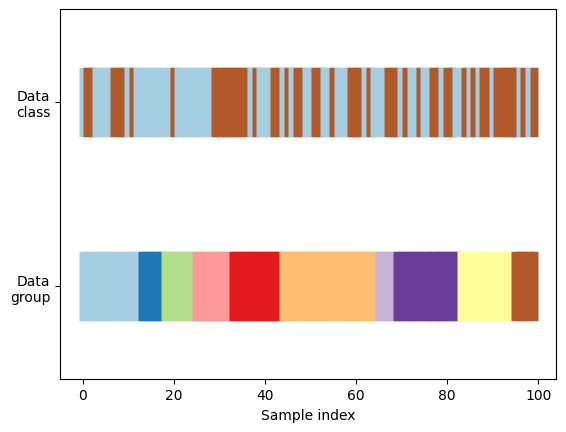

In [17]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

n_points = 100
X = rng.randn(100, 10) # 100 by 10

np.random.seed(2023)
y = (np.random.rand(n_points) > 0.5).astype(int)  # modified to avoid groups having uniform label, len(y)=100 in this case

group_prior = rng.dirichlet([2] * 10) #generating uneven groups
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))

print(len(group_prior)) # 10
print(len(groups)) # 100

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

visualize_groups(y, groups, "no groups")

Let's further create another function to faciliate visualization. We then can run FLAML, evaluating the results on a cross-validation, without setting groups first. This applies the default split settings:

In [18]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object.
       Function source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
    """

    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)): # generating the training/test visualizations for each CV split
        indices = np.array([np.nan] * len(X)) # filling in indices with training/test groups
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    ) # plotting the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    ) # plotting the data classes and groups at the end

    yticklabels = list(range(n_splits)) + ["class", "group"] # formatting
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)

[flaml.automl.logger: 11-13 21:15:30] {1728} INFO - task = classification
[flaml.automl.logger: 11-13 21:15:30] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 11-13 21:15:30] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 11-13 21:15:30] {1955} INFO - List of ML learners in AutoML Run: ['rf', 'kneighbor', 'xgboost']
[flaml.automl.logger: 11-13 21:15:30] {2258} INFO - iteration 0, current learner rf
[flaml.automl.logger: 11-13 21:15:30] {2393} INFO - Estimated sufficient time budget=4740s. Estimated necessary time budget=8s.
[flaml.automl.logger: 11-13 21:15:30] {2442} INFO -  at 0.5s,	estimator rf's best error=0.4697,	best estimator rf's best error=0.4697
[flaml.automl.logger: 11-13 21:15:30] {2258} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 11-13 21:15:31] {2442} INFO -  at 0.6s,	estimator xgboost's best error=0.4305,	best estimator xgboost's best error=0.4305
[flaml.automl.logger: 11-13 21:15:31] {2258} INFO - iteration 2, cu

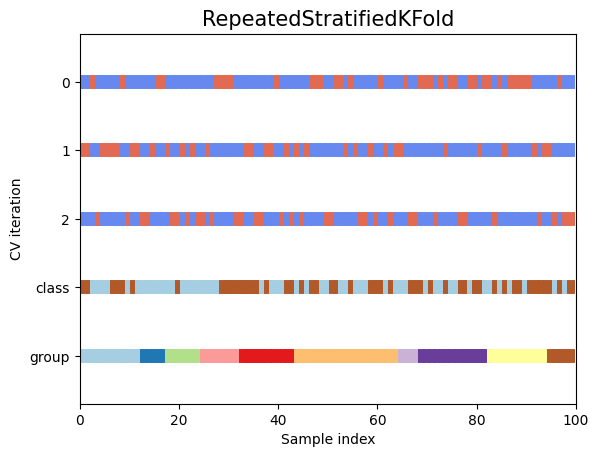

In [19]:
automl = AutoML()
automl_settings = {
    "time_budget": 3,  # total running time in seconds
    "metric": 'accuracy', 
    "estimator_list": ["rf", "kneighbor", "xgboost"],
    "task": 'classification',  # task type    
    "log_file_name": 'undestanding_cross_validation_default.log',
    "log_training_metric": True,  # whether to log training metric
    "keep_search_state": True, # needed if you want to keep the cross validation information
    "eval_method": "cv",
    #"split_type": "group",
    #"groups": groups,
    "n_splits": 3
}

automl.fit(X, y, **automl_settings)

f, ax = plt.subplots(1,1)
plot_cv_indices(automl._state.kf, X, y, groups, ax, automl._state.kf.get_n_splits())

Now let's set the split type to groups and provide the groups to run a GroupKFold instead. Compare with the previous visualization:

[flaml.automl.logger: 11-13 21:15:33] {1728} INFO - task = classification
[flaml.automl.logger: 11-13 21:15:33] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 11-13 21:15:33] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 11-13 21:15:33] {1955} INFO - List of ML learners in AutoML Run: ['rf', 'kneighbor', 'xgboost']
[flaml.automl.logger: 11-13 21:15:33] {2258} INFO - iteration 0, current learner rf
[flaml.automl.logger: 11-13 21:15:34] {2393} INFO - Estimated sufficient time budget=3440s. Estimated necessary time budget=6s.
[flaml.automl.logger: 11-13 21:15:34] {2442} INFO -  at 0.4s,	estimator rf's best error=0.4798,	best estimator rf's best error=0.4798
[flaml.automl.logger: 11-13 21:15:34] {2258} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 11-13 21:15:34] {2442} INFO -  at 0.5s,	estimator xgboost's best error=0.4191,	best estimator xgboost's best error=0.4191
[flaml.automl.logger: 11-13 21:15:34] {2258} INFO - iteration 2, cu

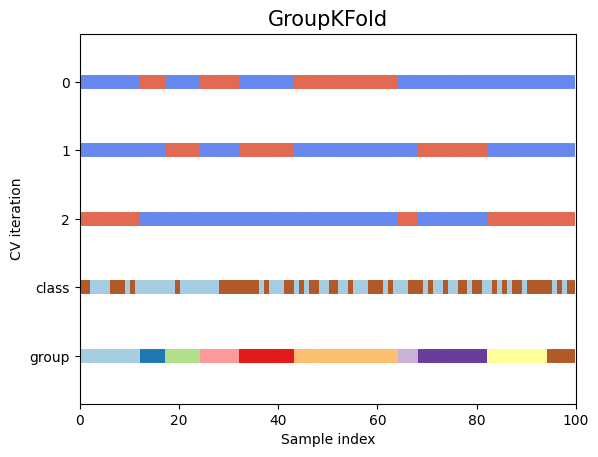

In [20]:
automl_settings["split_type"] = "group"
automl_settings["groups"] = groups
automl_settings["log_file_name"] = 'undestanding_cross_validation_groupkfold.log'

automl = AutoML()
automl.fit(X, y, **automl_settings)

f, ax = plt.subplots(1,1)
plot_cv_indices(automl._state.kf, X, y, groups, ax, automl._state.kf.get_n_splits())

#### Parallel Tuning and Warm Start

When you have parallel resources, you can either spend them in training and keep the model search sequential, or perform parallel search. You can either use the `ray` package or Spark to do parallel tuning. The documentation has more details. 

We can warm start the AutoML by providing starting points of hyperparameter configurstions for each estimator. For example, if you have run AutoML for one hour, after checking the results, you would like to run it for another two hours, then you can use the best configurations found for each estimator as the starting points for the new run.

In [21]:
titanic = fetch_openml('titanic', version=1, as_frame=True)
data = titanic.frame
features = ["pclass", "sex", "sibsp", "parch", "embarked"]
target = "survived"
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = pd.get_dummies(X_train[features])
X_test  = pd.get_dummies(X_test[features])

automl = AutoML()
automl.fit(X_train, y_train, time_budget=60, task="classification")
automl_cont = AutoML()
automl_cont.fit(
    X_train,
    y_train,
    time_budget=60,
    task="classification",
    starting_points=automl.best_config_per_estimator,
)

y_hat = automl_cont.predict(X_test)
eval_metric = accuracy_score(y_test , y_hat)
print("The evaluation score is %.5f" % eval_metric)

[flaml.automl.logger: 11-13 21:15:37] {1728} INFO - task = classification
[flaml.automl.logger: 11-13 21:15:37] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 11-13 21:15:37] {1838} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 11-13 21:15:37] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 11-13 21:15:37] {2258} INFO - iteration 0, current learner lgbm


C:\Users\PGAO\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


[flaml.automl.logger: 11-13 21:15:37] {2393} INFO - Estimated sufficient time budget=1323s. Estimated necessary time budget=33s.
[flaml.automl.logger: 11-13 21:15:37] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.1834,	best estimator lgbm's best error=0.1834
[flaml.automl.logger: 11-13 21:15:37] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-13 21:15:37] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.1834,	best estimator lgbm's best error=0.1834
[flaml.automl.logger: 11-13 21:15:37] {2258} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 11-13 21:15:37] {2442} INFO -  at 0.4s,	estimator lgbm's best error=0.1812,	best estimator lgbm's best error=0.1812
[flaml.automl.logger: 11-13 21:15:37] {2258} INFO - iteration 3, current learner sgd
[flaml.automl.logger: 11-13 21:15:37] {2442} INFO -  at 0.6s,	estimator sgd's best error=0.1941,	best estimator lgbm's best error=0.1812
[flaml.automl.logger: 11-13 21:15:37] {2258} INFO - iteration 4

### III. Retrieving the Outcome

We can obtain the best model this way:

In [22]:
automl_settings = {
    "time_budget": 30,  # in seconds
    "metric": "accuracy",
    "task": "classification",
    "log_file_name": "mylog.log",
    "verbose": False}

titanic = fetch_openml('titanic', version=1, as_frame=True)
data = titanic.frame
features = ["pclass", "sex", "sibsp", "parch", "embarked"]
target = "survived"
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = pd.get_dummies(X_train[features])
X_test  = pd.get_dummies(X_test[features])

automl = AutoML()
automl.fit(X_train, y_train, **automl_settings)
print(automl.model)
print(automl.model.estimator)
print(automl.best_estimator)
print(automl.best_config)
print(automl.best_config_per_estimator)
print(automl.best_config_train_time)
print(automl.best_iteration)
print(automl.best_loss)
print(automl.time_to_find_best_model)

C:\Users\PGAO\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.9706603459860277, colsample_bynode=None,
              colsample_bytree=0.8454846704595121, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=4,
              min_child_weight=0.8021745972157645, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)
xgboost
{'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.8021745972157645, 'learning_rate': 1.0, 'subsample': 0.923723172598251, 'colsample_bylevel': 0.9706603459860277, 'colsample_by

We can also get the learning curve. To plot how the loss is improved over time during the model search, first load the search history from the log file. Then, we can plot the metric versus wallclock time. The curve below suggests that increasing the time budget may not further improve the accuracy any more

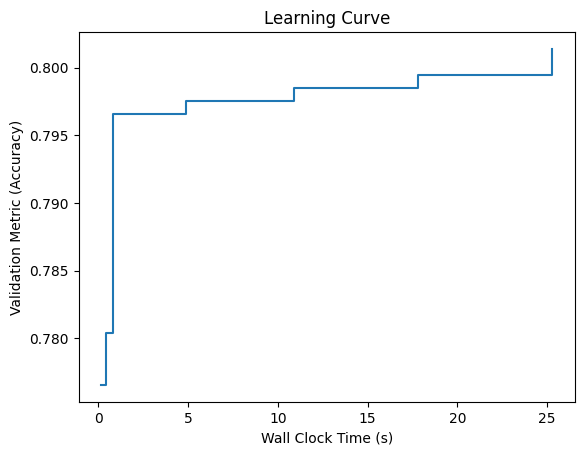

In [23]:
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename=automl_settings["log_file_name"], time_budget=120)
plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation Metric (Accuracy)")
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.show()

#### How much Time is Needed

If you want to get a sense of how much time is needed to find the best model, you can use _max\_iter_=2 to perform two trials first. The message will be like:

     INFO - iteration 0, current learner lgbm
     INFO - Estimated sufficient time budget=145194s. Estimated necessary time budget=2118s.
     INFO - at 2.6s, estimator lgbm's best error=0.4459, best estimator lgbm's best error=0.4459

You will see that the time to finish the first and cheapest trial is 2.6 seconds. The estimated necessary time budget is 2118 seconds, and the estimated sufficient time budget is 145194 seconds. Note that this is only an estimated range to help you decide your budget.

When the time budget is set too low, it can happen that no estimator is trained at all within the budget. In this case, it is recommanded to use _max\_iter_ instead of _time\_budget_. This ensures that you have enough time to train a model without worring about variance of the execution time for the code before starting a trainning.


### References:

   - https://microsoft.github.io/FLAML/docs/Getting-Started
   - https://microsoft.github.io/FLAML/docs/Installation
   - https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML
   - https://github.com/microsoft/FLAML/blob/main/notebook/basics/understanding_cross_validation.ipynb
   - https://arxiv.org/abs/1109.0887
